In [33]:
# import CartPole.py from local directory
import CartPole, sf3utility
import matplotlib.collections
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate, scipy.stats.qmc, scipy.optimize
import random, copy

plt.rcParams["font.family"] = "Georgia"
#plt.rcParams['figure.figsize'] = [9.0, 7.0]
#plt.rcParams['figure.dpi'] = 400

# store results for later
cache = {}

In [34]:
# allows nice plots that can be redrawn
%matplotlib notebook

# Task 2.1 - Nonlinear Modelling

In [35]:
# ChatPGT version

# 1. Data preparation

# Set the seed for the random number generator to ensure reproducibility
np.random.seed(4)

# Total number of states to generate
N = 512

# Generate random initial conditions for the CartPole
random_positions  = np.random.rand(N) * 20 - 10
random_velocities = np.random.rand(N) * 20 - 10
random_angles     = np.random.rand(N) * np.pi * 2 - np.pi
random_angvels    = np.random.rand(N) * 30 - 15

# Combine the generated conditions into a single array
initial_states = np.stack([random_positions, random_velocities, random_angles, random_angvels]).T

# Use a Sobol sequence for generating quasi-random numbers for another set of initial states
sobol_engine = scipy.stats.qmc.Sobol(d=4, seed=4)

# Calculate the logarithm base 2 of N and convert it to an integer
log_N = int(np.log2(N))

# Generate quasi-random numbers and adjust their scale
sobol_randoms = sobol_engine.random_base2(m=log_N) - 0.5
scaled_sobol_randoms = sobol_randoms * 2 * np.array([10, 10, np.pi, 15])

# Replace the initial states with the new Sobol-generated states
initial_states = scaled_sobol_randoms

# Placeholder for state changes
state_changes = []

# For each initial state
for state in initial_states:
    # Compute how the state changes when an action is performed
    change = CartPole.perform_action(state) - state
    state_changes.append(change)

# Convert the state changes to a numpy array
state_changes = np.array(state_changes)



# 2. Kernel Computation and Model Fitting

# Set the number of kernel centres
M = 16

# Create kernel_centres by selecting the first M elements from the initial states
kernel_centres = initial_states[:M]

# Adjust the total number of states to generate
N = 512 * 8

# Update the Sobol sequence generator with the new seed
sobol_engine = scipy.stats.qmc.Sobol(d=4, seed=3)

# Generate new Sobol-generated states and replace the initial states
log_N = int(np.log2(N))
sobol_randoms = sobol_engine.random_base2(m=log_N) - 0.5
scaled_sobol_randoms = sobol_randoms * 2 * np.array([10, 20, np.pi, 20])
initial_states = scaled_sobol_randoms

# Clear the state_changes list and compute new state changes
state_changes = []
for state in initial_states:
    change = CartPole.perform_action(state) - state
    state_changes.append(change)
state_changes = np.array(state_changes)

# Update the number of kernel centres and the kernel_centres
M = 32 * 32
kernel_centres = initial_states[:M]

# Compute sigma which is the standard deviation of initial states
sigma = np.std(initial_states, axis=0)

# Define the kernel function, K
# def K(X, Xp, sigma=sigma):
#     d2 = ((X - Xp) / sigma) ** 2
#     d2[:,2] = (np.sin(0.5 * (X[:,2] - Xp[:,2])) / sigma[2]) ** 2
#     return np.exp(-0.5 * np.sum(d2, axis=1))
# Define the kernel function, K
def K(X, Xp, sigma=sigma):
    X = np.atleast_2d(X)
    Xp = np.atleast_2d(Xp)

    # The np.newaxis is added to increase the dimension for broadcasting
    d2 = ((X[:, np.newaxis, :] - Xp) / sigma) ** 2
    d2[:, :, 2] = (np.sin(0.5 * (X[:, np.newaxis, 2] - Xp[:, 2])) / sigma[2]) ** 2
    return np.exp(-0.5 * np.sum(d2, axis=2))


# Compute Kmm and Kmn
Kmm = np.zeros((M, M))
Kmn = np.zeros((M, N))
for i, kernel_centre in enumerate(kernel_centres):
    Kmm[i] = K(initial_states[:M], kernel_centre[np.newaxis])
    Kmn[i] = K(initial_states, kernel_centre[np.newaxis])

# Compute alpha_m
l = 1e-4
a = Kmn @ Kmn.T + l * Kmm
b = Kmn @ state_changes
alpha_m = np.linalg.lstsq(a, b, rcond=None)[0]



# 3. Model Prediction

# Define the nonlinear_model function
def nonlinear_model(state):
    kernels = K(state[np.newaxis], kernel_centres)
    weighted_sums = kernels @ alpha_m
    return weighted_sums.squeeze()

# Set up the initial conditions for the grid
Nsteps = 30
initial_cart_positions  = np.array([2])
initial_cart_velocities = np.array([4])
initial_pole_angles     = np.linspace(-np.pi, np.pi, num=Nsteps)
initial_pole_angvels    = np.linspace(-15, 15, num=Nsteps)

# Create the grid of initial states
initial_states = np.array(np.meshgrid(initial_cart_positions, 
                                       initial_cart_velocities, 
                                       initial_pole_angles, 
                                       initial_pole_angvels)).T.squeeze()

# Generate state changes and model predictions for the initial states grid
state_changes = []
modelled_changes = []
for state in initial_states.reshape((Nsteps**2,4)):
    state_change = CartPole.perform_action(state) - state
    state_changes.append(state_change)
    modelled_change = nonlinear_model(state)
    modelled_changes.append(modelled_change)

# Convert the state changes and modelled changes to numpy arrays and reshape them
state_changes = np.array(state_changes).reshape((Nsteps, Nsteps, 4))
modelled_changes = np.array(modelled_changes).reshape((Nsteps, Nsteps, 4))



# 4. Visualisation

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, num=19, figsize=(9, 9))
fig.subplots_adjust(wspace=0.16, hspace=0.16, top=0.92, bottom=0.08, left=0.08, right=0.96)

# Set plot titles
titles = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"]

# Generate the predictions for all initial states
predictions = np.array([nonlinear_model(state) for state in initial_states])

# Plot the data
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    x, y = predictions[:,i], state_changes[:,i]
    c = np.abs(x - y)
    extent = np.max((np.concatenate([x, y]))) * 1.2
    ax.scatter(y, x, s=1, c=c, cmap="cool", zorder=2)
    ax.set_xlim(-extent, extent)
    ax.set_ylim(-extent, extent)
    ax.plot([-extent, extent], [-extent, extent], color="black", linestyle="dotted", zorder=1)
    ax.set_title(titles[i])

# Set figure titles
fig.text(0.5, 0.97, 'Predicted State Changes vs. Target State Changes', ha='center', va='center', fontsize=16)
fig.text(0.52, 0.03, 'Target State Change', ha='center', va='center', fontsize=14)
fig.text(0.03, 0.5, 'Predicted State Change', ha='center', va='center', rotation='vertical', fontsize=14)


ValueError: could not broadcast input array from shape (1024,1) into shape (1024,)

## Generating Training Data

Now that I wish to improve the state change model with nonlinear basis functions, the first task is to generate training data. For task 1.3 I used uniformly distributed random datapoints, but this time I am using a sobol sequence to generate more evenly spaced data.

In [ ]:
N = 512

np.random.seed(4)

random_positions  = np.random.rand( N ) * 20 - 10
random_velocities = np.random.rand( N ) * 20 - 10
random_angles     = np.random.rand( N ) * np.pi * 2 - np.pi
random_angvels    = np.random.rand( N ) * 30 - 15

# stack random values into 512 state vectors

X_random = initial_states = np.stack( [
    random_positions,
    random_velocities,
    random_angles,
    random_angvels
] ).T


# set the random seed and create the sobol sequence generator
sobol_engine = scipy.stats.qmc.Sobol( d=4, seed=4 )

# get 512 initial states spaced in the recommended ranges
X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 10, np.pi, 15 ] )

# generate the changes in state from these states
Y = np.array( [ CartPole.perform_action( state ) - state for state in initial_states ] )


M = 16
kernel_centres = X[:M]

In [ ]:
fig, (ax1, ax2) = plt.subplots( 1, 2, num=1, sharey=True, figsize=(9,4.5) )
fig.subplots_adjust(wspace=0.05, bottom=0.15)

c = np.zeros( N )
for i, x in enumerate( X_random ):
    
    c[i] = np.linalg.norm( np.exp( -3*(X_random[:,0:2] - x[0:2])**2 ) )

ax1.scatter( X_random[:,0], X_random[:,1], s=2, c=c, cmap="cool", label="Datapoints" )
ax1.scatter( X_random[:M,0], X_random[:M,1], s=50, color=[0,0,0,0], edgecolors="cyan", linewidths=2, label="Kernel Centres" )

ax1.set_title( "Randomly Selected Points" )
ax1.legend( loc="upper left", prop={'size': 9}, facecolor='white', framealpha=1 )


c = np.zeros( N )
for i, x in enumerate( X_sobol ):
    
    c[i] = np.linalg.norm( np.exp( -3*(X_sobol[:,0:2] - x[0:2])**2 ) )


ax2.scatter( X_sobol[:,0], X_sobol[:,1], s=2, c=c, cmap="cool", label="Datapoints" )
ax2.scatter( kernel_centres[:,0], kernel_centres[:,1], s=50, color=[0,0,0,0], edgecolors="cyan", linewidths=2, label="Kernel Centres" )

ax2.set_title( "Sobol Sequence Points" )
ax2.legend( loc="upper left", prop={'size': 9}, facecolor='white', framealpha=1 )


fig.text( 0.06, 0.5, "Initial Cart Velocity", rotation="vertical", ha="center", va="center", fontsize=12 )
fig.text( 0.5, 0.05, "Initial Cart Position", ha="center", va="center", fontsize=12 )


## Sobol Sequence

Above are scatter plots of the datapoints generated by the two methods, projected onto the plane formed by the first two state vector dimensions. The dots represent datapoints, and the circled points represent basis function centres. The randomly selected points can be bunched up in some areas, and absent from others. The sobol sequence provides much better coverage of the state space, meaning more useful information makes it into the model.

## Selection of Kernel Centres

The sobol sequence method has another advantage: the first few generated points are also evenly spaced over the state space so they work well as kernel centres (if two kernel centres were next to each other, they would explain the same part of the data so one would be enough). This works best when the number of kernel centres is a power of two; above I have selected the first 16 points as basis function centres. The left plot shows the result of random basis function centre generation, where some kernel centres are very close to each other and there is a large gap in the top left which would lead to poor modelling in that region.

## Creating More Training Data

In [ ]:
N = 512 * 8

np.random.seed(4)

# set the random seed and create the sobol sequence generator
sobol_engine = scipy.stats.qmc.Sobol( d=4, seed=3 )

# get N initial states spaced in the recommended ranges
X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 20, np.pi, 20 ] )
#X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 5, 2, 1, 2 ] ) + np.array([0,0,np.pi,0])
#X[:,2] = np.array( [ CartPole.remap_angle(theta) for theta in X[:,2] ] )

# generate the changes in state from these states
Y = np.array( [ CartPole.perform_action( state ) - state for state in initial_states ] )


M = 32 * 32
kernel_centres = X[:M]

cache["X_Y_M_N_kc_fit"] = tuple( copy.deepcopy(x) for x in [X, Y, M, N, kernel_centres])

## Define the Nonlinear Kernel

In [ ]:
sigma = np.std( X, axis=0 )

def K( X, Xp, sigma = sigma ):
    
    # get squared differences and substitute angle one for periodic version
    d2 = ( (X - Xp) / sigma ) ** 2
    d2[:,2] = (np.sin( 0.5 * ( X[:,2] - Xp[:,2] ) ) / sigma[2] ) ** 2
    
    # divide rows by 2 sigma and return exponential of negative sum along rows
    return np.exp( - 0.5 * np.sum( d2, axis=1 ) )
    
cache["sigma_fitted"] = copy.deepcopy(sigma)

## Construction of Knm Matrices

In [ ]:
# loop over the kernel centres and evaluate the K function across all the Xs at each
Kmn = np.zeros( (M,N) )
for i, kernel_centre in enumerate( kernel_centres ):
    
    Kmn[i] = K( X, kernel_centre[np.newaxis] )
    
# same as above but only use first M vectors from X
Kmm = np.zeros( (M,M) )
for i, kernel_centre in enumerate( kernel_centres ):
    
    Kmm[i] = K( X[:M], kernel_centre[np.newaxis] )

## Finding the Kernel Coefficients

In [ ]:
l = 1e-4

KmnKnm = Kmn @ Kmn.T
a = KmnKnm + l * Kmm
b = Kmn @ Y

alpha_m = np.linalg.lstsq( a, b, rcond=None )[0]

cache["alpha_m_fitted"] = copy.deepcopy( alpha_m )
cache["kernel_centres_fitted"] = copy.deepcopy( kernel_centres )

## Building the Model

In [ ]:
def nonlinear_model( state ):
    
    kernels = K( state[np.newaxis], kernel_centres )
    
    weighted_sums = kernels @ alpha_m
    
    return weighted_sums.squeeze()

cache["nonlinear_model_fitted"] = copy.deepcopy(nonlinear_model)

## Evaluating the Model

In [36]:
# sweep over different initial pole angles and angvels and find the subsequent change in state

# number of steps to vary the intial conditions across their range
Nsteps = 30

# setup some intial conditions to loop over, varying the intial pole angle and angular velocity

initial_cart_positions  = np.array( [2] )
initial_cart_velocities = np.array( [4] )
initial_pole_angles     = np.linspace( -np.pi, np.pi, num=Nsteps )
initial_pole_angvels    = np.linspace( -15, 15, num=Nsteps )

# create array of initial state vectors

initial_states = np.array( np.meshgrid(
    initial_cart_positions, 
    initial_cart_velocities, 
    initial_pole_angles, 
    initial_pole_angvels 
)).T.squeeze()

# get 2d arrays of subsquent state changes and predictions

state_changes = [ CartPole.perform_action( state ) - state for state in initial_states.reshape( (Nsteps**2,4) ) ]
state_changes = np.array( state_changes ).reshape( (Nsteps, Nsteps, 4) )

modelled_changes = [ nonlinear_model( state ) for state in initial_states.reshape( (Nsteps**2,4) ) ]
modelled_changes = np.array( modelled_changes ).reshape( (Nsteps, Nsteps, 4) )

ValueError: cannot reshape array of size 4500 into shape (30,30,4)

In [ ]:
fig, axs = plt.subplots(2, 4, num=4, figsize=(12,6), sharex=True, sharey=True )
fig.subplots_adjust(wspace=0.05, hspace=0.2, top=0.84, bottom=0.12, left=0.1, right=0.9)

titles = [["Cart Position - Actual", "Cart Velocity - Actual", "Pole Angle - Actual", "Pole Angular Velocity - Actual"],
          ["Cart Position - Predicted", "Cart Velocity - Predicted", "Pole Angle - Predicted", "Pole Angular Velocity - Predicted"]]

# plot nonlinear prediction contours

for row, axrow in enumerate(axs):
    
    changes = [ state_changes, modelled_changes ][row]
    
    for col, ax in enumerate(axrow):

        ax.imshow( changes[:,:,col], interpolation="bicubic", extent=(-np.pi, np.pi, -15, 15), aspect='auto', cmap="cool", origin='lower' )
        contour = ax.contour( initial_states[0,:,2], initial_states[:,0,3], changes[:,:,col], colors="white", linewidths=1 )
        ax.clabel( contour, contour.levels[1::2], inline=True, fontsize=12 )
        
        ax.set_title( titles[row][col] )
    
fig.text(0.5, 0.94, 'State Changes vs. Nonlinear Prediction Thereof', ha='center', va='center', fontsize=16)
fig.text(0.5, 0.05, 'Initial Pole Angle', ha='center', va='center', fontsize=14)
fig.text(0.06, 0.5, 'Initial Pole Angular Velocity', ha='center', va='center', rotation='vertical', fontsize=14)


Above are the contour plots of the nonlinear predictions for the state changes, across varying intial pole angle and angular velocity. The nonlinear structure has been captured by the model quite well but it did take a large amount of data and many kernel functions to acheive this. The hyperparameters sigma and lambda were identified by trial and error. Improvements to the process might include collecting data further outside the region we would like to make predictions in, pushing errors further away from where we are using the model for prediction. Another improvement could be to collect more datapoints in regions with larger errors, or assign different "weights" to different data points, making them more or less important for the model to explain well.

## Plotting Predicted State Changes Against Target State Changes

<IPython.core.display.Javascript object>


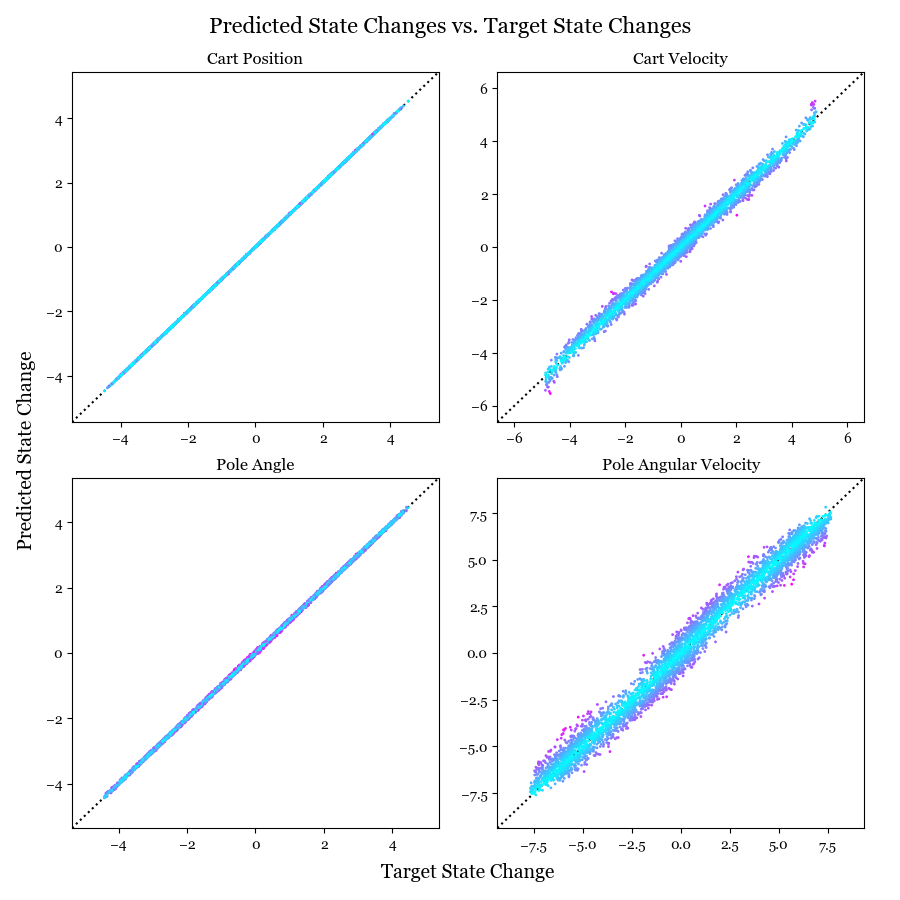

Text(0.03, 0.5, 'Predicted State Change')

In [14]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, num=19, figsize=(9,9))
fig.subplots_adjust(wspace=0.16, hspace=0.16, top=0.92, bottom=0.08, left=0.08, right=0.96)

titles = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"]

predictions = np.array( [ nonlinear_model(state) for state in X ] )

for i, ax in enumerate( [ax1, ax2, ax3, ax4] ):
    
    x, y = predictions[:,i], Y[:,i]
    c = np.abs(x - y)
    
    extent = np.max( ( np.concatenate([x, y]) ) ) * 1.2
    
    ax.scatter( y, x, s=1, c=c, cmap="cool", zorder=2 )
    ax.set_xlim(-extent, extent)
    ax.set_ylim(-extent, extent)
    
    ax.plot( [-extent, extent], [-extent, extent], color="black", linestyle="dotted", zorder=1 )
    
    ax.set_title( titles[i] )
    
fig.text(0.5, 0.97, 'Predicted State Changes vs. Target State Changes', ha='center', va='center', fontsize=16)
fig.text(0.52, 0.03, 'Target State Change', ha='center', va='center', fontsize=14)
fig.text(0.03, 0.5, 'Predicted State Change', ha='center', va='center', rotation='vertical', fontsize=14)
    

Above I have plotted the target state change against the predictions from the linear plus nonlinear model. The points are all lying much closer to the ideal line y=x, so we can expect this model to preform much better than the linear model from task 1.3.

In [21]:
X, Y, M, N, kernel_centres = cache["X_Y_M_N_kc_fit"]
sigma = cache["sigma_fitted"]
kernel_centres = cache["kernel_centres_fitted"]


fig, axs = plt.subplots(1, 6, num=9, figsize=(14,5), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.05, top=0.86, bottom=0.12, left=0.06, right=0.99)

Ms = [5,10,15,25,40,100]

for p, ax in enumerate( axs ):

    M = int( 5 + 12*p**1.5 )
    #M = Ms[p]
    kernel_centres = X[:M]

    # loop over the kernel centres and evaluate the K function across all the Xs at each
    Kmn = np.zeros( (M,N) )
    for i, kernel_centre in enumerate( kernel_centres ):

        Kmn[i] = K( X, kernel_centre[np.newaxis] )

    # same as above but only use first M vectors from X
    Kmm = np.zeros( (M,M) )
    for i, kernel_centre in enumerate( kernel_centres ):

        Kmm[i] = K( X[:M], kernel_centre[np.newaxis] )


    l = 1e-4

    KmnKnm = Kmn @ Kmn.T
    a = KmnKnm + l * Kmm
    b = Kmn @ Y

    alpha_m = np.linalg.lstsq( a, b, rcond=None )[0]

    Npoints = 1024
    
    predictions = np.array( [ nonlinear_model(state) for state in X[:Npoints] ] )

    x, y = predictions[:,3], Y[:Npoints,3]
    c = np.abs(x - y)

    extent = 10

    ax.scatter( y, x, s=1, c=c, cmap="cool", zorder=2 )
    ax.set_xlim(-extent, extent)
    ax.set_ylim(-extent, extent)

    ax.plot( [-extent, extent], [-extent, extent], color="black", linestyle="dotted", zorder=1 )

    ax.set_title( f'{M} Kernels' )
    ax.set_xticklabels( [" ","-5","0","5","10"] )

fig.text(0.5, 0.96, 'Convergence of Model with Addition of Basis Functions - Predictions of Angular Velocity Change', ha='center', va='center', fontsize=16)
fig.text(0.52, 0.03, 'Target State Change', ha='center', va='center', fontsize=14)
fig.text(0.025, 0.5, 'Predicted State Change', ha='center', va='center', rotation='vertical', fontsize=14)



C:\Users\airbl\AppData\Local\Temp\ipykernel_30064\3088777172.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( [" ","-5","0","5","10"] )


Text(0.025, 0.5, 'Predicted State Change')

Above I have plotted the prediction for change in pole angular velocity against the actual change for a increasing numbers of basis functions. As the number of basis functions increases, the fit converges but plateaus before acheiving a perfect fit. Increasing the number of datapoints fed into the model has a similar effect, but fitting the model with more datapoints provides a modelling improvement that only increases computation time during fitting whereas increasing the number of kernel centres increases computation time during fitting and model evaluation.

## Performing Rollouts with the Nonlinear Model

In [37]:
X, Y, M, N, kernel_centres = cache["X_Y_M_N_kc_fit"]
kernel_centres = cache["kernel_centres_fitted"]
alpha_m = cache["alpha_m_fitted"]
sigma = cache["sigma_fitted"]
nonlinear_model = cache["nonlinear_model_fitted"]

fig, ax = plt.subplots(1, 1, num=15, figsize=(10,2.5))
fig.subplots_adjust(bottom=0.2, right=0.99, left=0.1)
sf3utility.setup_phase_portrait( ax )

# small oscillations about stable equilibrium

predicted_state = np.array( [0, -2, np.pi, 4] )
actual_state = np.array( [0, -2, np.pi, 4] )

prediction_states = []
actual_states = []
time = []

for i in range(50):
    
    prediction_states.append( predicted_state )
    actual_states.append( actual_state )
    time.append( i * 0.2 )
    
    predicted_state = nonlinear_model( predicted_state ) + predicted_state
    actual_state    = CartPole.perform_action( actual_state )

prediction_states = np.array( prediction_states )
actual_states = np.array( actual_states )
time = np.array( time )

x = time
y1 = prediction_states[:,1]
y2 = actual_states[:,1]


f, u = scipy.interpolate.splprep( [x, y1], s=0, per=True )
xint, y1int = scipy.interpolate.splev(np.linspace(0, 1, 10000), f)
xint, y1int = xint[:5000], y1int[:5000]

f, u = scipy.interpolate.splprep( [x, y2], s=0, per=True )
_, y2int = scipy.interpolate.splev(np.linspace(0, 1, 10000), f)
y2int = y2int[:5000]

ax.plot( x, y2, color="orange", linewidth=2, label="Actual" )
ax.plot( x, y1, color="magenta", linewidth=2, label="Nonlinear Model" )

ax.set_title("Nonlinear Model Time Evolution Prediction vs. Actual")
ax.set_xlabel("Seconds Elapsed")
ax.set_ylabel("Cart Velocity")

KeyError: 'X_Y_M_N_kc_fit'

Above, I have plotted the time evolution of the system as predicted by the nonlinear model, in magenta, and according to the analytic equations in orange. I have plotted the evolution of the cart velocity only because I found while experimenting that if the time evolution of one of the states matches then they all will, and divergence of one state indicates total divergence. Therefore all the meaning I was interested in was contained in the time evolution of a single element of the state vector, and allows me to save space for the final report etc.

There is reasonable agreement up to 5 seconds, and diagreement beyond. The mispredictions up to 5 seconds are due to accumulating errors in the model, but the deviation at 5 seconds is indicative of a weakness in the model. At this point, the cart has been moving left at about 2 metres per second for 5 seconds, so has moved 10 metres. The training data and basis function centres were all generated with cart positions within -10 to 10 in state space, so after 5 seconds the cart has moved away from all the kernel centres into a region of the state space that is necessarily badly described by the model.

## Model Ignoring Cart Position

So, I adjusted the kernel function to ignore the cart position dimension (which has no effect on the change in state anyway) and refitted the model. The resulting prediction is shown in cyan and is not an exact match to the real dynamics in orange but exhibits more similar overall behaviour. It is also worth noting that when in use, the controller will keep the cart position close to the origin so this adjustment may be inconsequential in that case.

In [38]:
N = 512 * 8

# set the random seed and create the sobol sequence generator
sobol_engine = scipy.stats.qmc.Sobol( d=4, seed=4 )

# get M initial states spaced in the recommended ranges
X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 20, np.pi, 20 ] )
#X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 5, 2, 1, 2 ] ) + np.array([0,0,np.pi,0])
#X[:,2] = np.array( [ CartPole.remap_angle(theta) for theta in X[:,2] ] )

# generate the changes in state from these states
Y = np.array( [ CartPole.perform_action( state ) - state for state in initial_states ] )


M = 32 * 32
kernel_centres = X[:M]


sigma = np.std( X, axis=0 ) * 0.9

def K( X, Xp, sigma = sigma ):
    
    # get squared differences and substitute angle one for periodic version
    d2 = ( (X - Xp) / sigma ) ** 2
    d2[:,0] = 0
    d2[:,2] = (np.sin( 0.5 * ( X[:,2] - Xp[:,2] ) ) / sigma[2] ) ** 2
    
    # divide rows by 2 sigma and return exponential of negative sum along rows
    return np.exp( - 0.5 * np.sum( d2, axis=1 ) )
    
    
# loop over the kernel centres and evaluate the K function across all the Xs at each
Kmn = np.zeros( (M,N) )
for i, kernel_centre in enumerate( kernel_centres ):
    
    Kmn[i] = K( X, kernel_centre[np.newaxis] )
    
# same as above but only use first M vectors from X
Kmm = np.zeros( (M,M) )
for i, kernel_centre in enumerate( kernel_centres ):
    
    Kmm[i] = K( X[:M], kernel_centre[np.newaxis] )
    
    
l = 1e-4

KmnKnm = Kmn @ Kmn.T
a = KmnKnm + l * Kmm
b = Kmn @ Y

alpha_m = np.linalg.lstsq( a, b, rcond=None )[0]

def nonlinear_model( state ):
    
    kernels = K( state[np.newaxis], kernel_centres )
    
    weighted_sums = kernels @ alpha_m
    
    return weighted_sums.squeeze()

# small oscillations about stable equilibrium

predicted_state = np.array( [0, -2, np.pi, 3] )

prediction_states = []
time = []

for i in range(50):
    
    prediction_states.append( predicted_state )
    time.append( i * 0.2 )
    
    predicted_state = nonlinear_model( predicted_state ) + predicted_state

prediction_states = np.array( prediction_states )
time = np.array( time )

x = time
y1 = prediction_states[:,1]

ax.plot( x, y1, color="cyan", linewidth=2, label="Nonlinear Model Ignoring Cart Position" )

ax.legend( loc="upper left", prop={'size': 9}, facecolor='white', framealpha=1 )

In [39]:
N = 512 * 8

# set the random seed and create the sobol sequence generator
sobol_engine = scipy.stats.qmc.Sobol( d=4, seed=4 )

# get M initial states spaced in the recommended ranges
#X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 20, np.pi, 20 ] )
X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 5, 2, 1, 2 ] ) + np.array([0,0,np.pi,0])
#X[:,2] = np.array( [ CartPole.remap_angle(theta) for theta in X[:,2] ] )

# generate the changes in state from these states
Y = np.array( [ CartPole.perform_action( state ) - state for state in initial_states ] )


M = 32 * 32
kernel_centres = X[:M]


sigma = np.std( X, axis=0 ) * 0.9

def K( X, Xp, sigma = sigma ):
    
    # get squared differences and substitute angle one for periodic version
    d2 = ( (X - Xp) / sigma ) ** 2
    d2[:,2] = (np.sin( 0.5 * ( X[:,2] - Xp[:,2] ) ) / sigma[2] ) ** 2
    
    # divide rows by 2 sigma and return exponential of negative sum along rows
    return np.exp( - 0.5 * np.sum( d2, axis=1 ) )
    
    
# loop over the kernel centres and evaluate the K function across all the Xs at each
Kmn = np.zeros( (M,N) )
for i, kernel_centre in enumerate( kernel_centres ):
    
    Kmn[i] = K( X, kernel_centre[np.newaxis] )
    
# same as above but only use first M vectors from X
Kmm = np.zeros( (M,M) )
for i, kernel_centre in enumerate( kernel_centres ):
    
    Kmm[i] = K( X[:M], kernel_centre[np.newaxis] )
    
    
l = 1e-4

KmnKnm = Kmn @ Kmn.T
a = KmnKnm + l * Kmm
b = Kmn @ Y

alpha_m = np.linalg.lstsq( a, b, rcond=None )[0]

def nonlinear_model( state ):
    
    kernels = K( state[np.newaxis], kernel_centres )
    
    weighted_sums = kernels @ alpha_m
    
    return weighted_sums.squeeze()

<IPython.core.display.Javascript object>


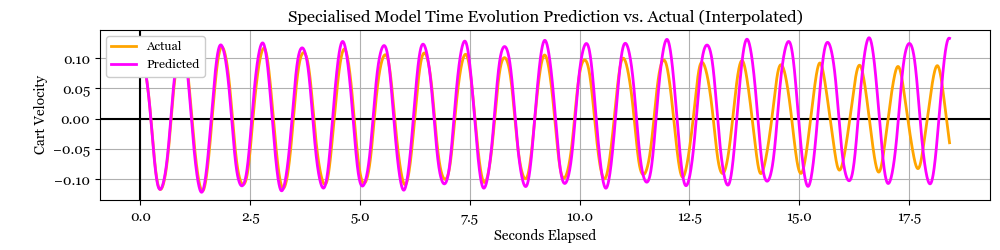

In [40]:
#kernel_centres = cache["kernel_centres_fitted"]
#alpha_m = cache["alpha_m_fitted"]

fig, ax = plt.subplots(1, 1, num=14, figsize=(10,2.5))
fig.subplots_adjust(bottom=0.2, right=0.99, left=0.1)
sf3utility.setup_phase_portrait( ax )

# small oscillations about stable equilibrium

predicted_state = np.array( [0, 0.126, np.pi, 1] )
actual_state = np.array( [0, 0.126, np.pi, 1] )

prediction_states = []
actual_states = []
time = []

for i in range(100):
    
    prediction_states.append( predicted_state )
    actual_states.append( actual_state )
    time.append( i * 0.2 )
    
    predicted_state = nonlinear_model( predicted_state ) + predicted_state
    actual_state    = CartPole.perform_action( actual_state )

prediction_states = np.array( prediction_states )
actual_states = np.array( actual_states )
time = np.array( time )

x = time
y1 = prediction_states[:,1]
y2 = actual_states[:,1]


f, u = scipy.interpolate.splprep( [x, y1], s=0, per=True )
xint, y1int = scipy.interpolate.splev(np.linspace(0, 1, 10000), f)
xint, y1int = xint[:5000], y1int[:5000]

f, u = scipy.interpolate.splprep( [x, y2], s=0, per=True )
_, y2int = scipy.interpolate.splev(np.linspace(0, 1, 10000), f)
y2int = y2int[:5000]

ax.plot( xint, y2int, color="orange", linewidth=2, label="Actual" )
ax.plot( xint, y1int, color="magenta", linewidth=2, label="Predicted" )

ax.set_title("Specialised Model Time Evolution Prediction vs. Actual (Interpolated)")
ax.set_xlabel("Seconds Elapsed")
ax.set_ylabel("Cart Velocity")

ax.legend( loc="upper left", prop={'size': 9}, facecolor='white', framealpha=1 )

## Descoping the Model

In order to improve the model's predictions, I restricted the training data to the range relevant to small amplitude oscillations and then examined the time evolution of the predictions exclusively within that same regime. The plot above shows the actual dynamics in orange, and the model predictions in magenta. The predictions are very good up to about 10 seconds, so training the model on only a subset of the data improves predictions in that neighbourhood significantly. Beyond about 7 seconds the real oscillations start to decay - the model struggles to capture this behaviour as it occurs over a larger timescale, while the model can predict only one timestep forward. 

## Nonlinear Model Evaluation

Above I found that the model is able to give agreement for many oscillations with a bit of tweaking, although errors always accumulate. This is to be expected: we trained the model with inputs and targets that were only 1 step apart, so intuitively the model can predict a single time step well but has no understanding that repeated evaluation amplifies undesirable errors. Although we see good predictions from the pointwise accuracy tests, the time evolution exacerbates these errors.

# Task 2.2 - Modelling Effect of Force Input

In [20]:
# sweep over different initial pole angles and angvels and find the subsequent change in state

# number of steps to vary the intial conditions across their range
Nsteps = 40

# setup some intial conditions to loop over, varying the intial pole angle and angular velocity

initial_cart_positions  = np.array( [2] )
initial_cart_velocities = np.array( [0] )
initial_pole_angles     = np.linspace( -np.pi, np.pi, num=Nsteps ) # np.array( [3] )
initial_pole_angvels    = np.array( [0] ) # np.linspace( -15, 15, num=Nsteps )
initial_actions         = np.linspace( -17, 17, num=Nsteps )

# create array of initial state vectors

initial_states = np.array( np.meshgrid(
    initial_cart_positions, 
    initial_cart_velocities, 
    initial_pole_angles, 
    initial_pole_angvels,
    initial_actions
)).T.squeeze()

# get 2d array of subsquent state vectors

state_changes = [ CartPole.perform_action_RK4( state ) - state for state in initial_states.reshape( (Nsteps**2,5) ) ]
state_changes = np.array( state_changes ).reshape( (Nsteps, Nsteps, 5) )

# cache data for later

#cache["state_changes_varying_angvel_and_force"] = state_changes

<IPython.core.display.Javascript object>


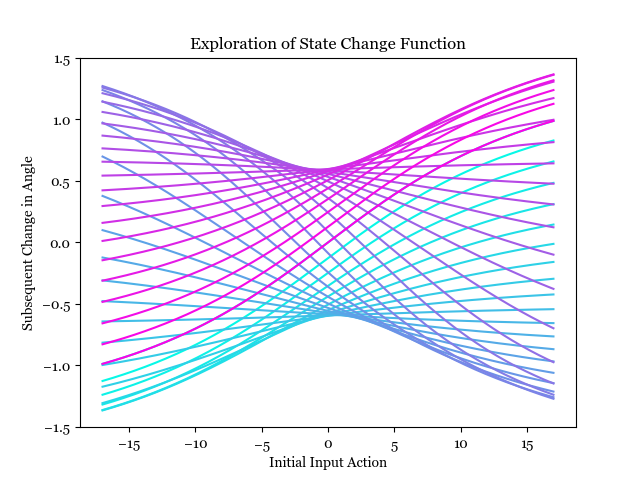

Text(0, 0.5, 'Subsequent Change in Angle')

In [22]:
fig, ax = plt.subplots(1, 1, num=8)  

# create array of interpolated colours 

col_lerp = np.linspace(0, 1, Nsteps)[np.newaxis].T
colours = ( 1 - col_lerp ) * np.array( [0, 255, 231, 255] )/255 + col_lerp * np.array( [255, 0, 230, 255] )/255


for i, row in enumerate(state_changes):
       
    # convert to arrays and extract certain components from vectors
    
    x = initial_states[:,i,4] # extract initial force
    y = state_changes[:,i,2] # extract change in angle
    
    # code to smooth plot lines
    
    xnew = np.linspace( x.min(), x.max(), 300 ) 

    y_spline = scipy.interpolate.make_interp_spline(x, y, k=2)
    y_smooth = y_spline(xnew)
    
    # plot then move onto next line

    ax.plot( xnew, y_smooth, color=colours[i] ) 

ax.set_title( "Exploration of State Change Function" )
ax.set_xlabel( "Initial Input Action" )
ax.set_ylabel( "Subsequent Change in Angle" )

## Effect of Input Force

The system now includes an input force, meaning the state space is one dimension larger. The input force affects the cartpole dynamics within the `perform_action` function, so by controlling this input it will be possible to hold the pendulum at its unstable equilibrium. In order to visualise the state change function with the force input, I plotted the graph above which shows how the initial angle and input action affect the subsequent change in angle. The different lines are different initial angles, from -pi in magenta to pi in cyan, and the input action is varying along the lines.

In [23]:
N = 512 * 8

# set the random seed and create the sobol sequence generator
sobol_engine = scipy.stats.qmc.Sobol( d=5, seed=4 )

# get M initial states spaced in the recommended ranges
X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 10, 20, np.pi, 20, 15 ] )
#X = X_sobol = initial_states = (sobol_engine.random_base2( m=int(np.log2(N)) ) - 0.5 ) * 2 * np.array( [ 2, 2, 1, 2, 1 ] ) + np.array([0,0,np.pi,0,0])
#X[:,2] = np.array( [ CartPole.remap_angle(theta) for theta in X[:,2] ] )

# generate the changes in state from these states
Y = np.array( [ CartPole.perform_action5( state ) - state for state in initial_states ] )


M = 32 * 32
kernel_centres = X[:M]


sigma = np.std( X, axis=0 )

def K( X, Xp, sigma = sigma ):
    
    # get squared differences and substitute angle one for periodic version
    d2 = ( (X - Xp) / sigma ) ** 2
    d2[:,0] = 0
    d2[:,2] = (np.sin( 0.5 * ( X[:,2] - Xp[:,2] ) ) / sigma[2] ) ** 2
    
    # divide rows by 2 sigma and return exponential of negative sum along rows
    return np.exp( - 0.5 * np.sum( d2, axis=1 ) )
    
    
# loop over the kernel centres and evaluate the K function across all the Xs at each
Kmn = np.zeros( (M,N) )
for i, kernel_centre in enumerate( kernel_centres ):
    
    Kmn[i] = K( X, kernel_centre[np.newaxis] )
    
# same as above but only use first M vectors from X
Kmm = np.zeros( (M,M) )
for i, kernel_centre in enumerate( kernel_centres ):
    
    Kmm[i] = K( X[:M], kernel_centre[np.newaxis] )
    
    
l = 1e-4

KmnKnm = Kmn @ Kmn.T
a = KmnKnm + l * Kmm
b = Kmn @ Y

alpha_m = np.linalg.lstsq( a, b, rcond=None )[0]

def nonlinear_model( state ):
    
    kernels = K( state[np.newaxis], kernel_centres )
    
    weighted_sums = kernels @ alpha_m
    
    return weighted_sums.squeeze()

<IPython.core.display.Javascript object>


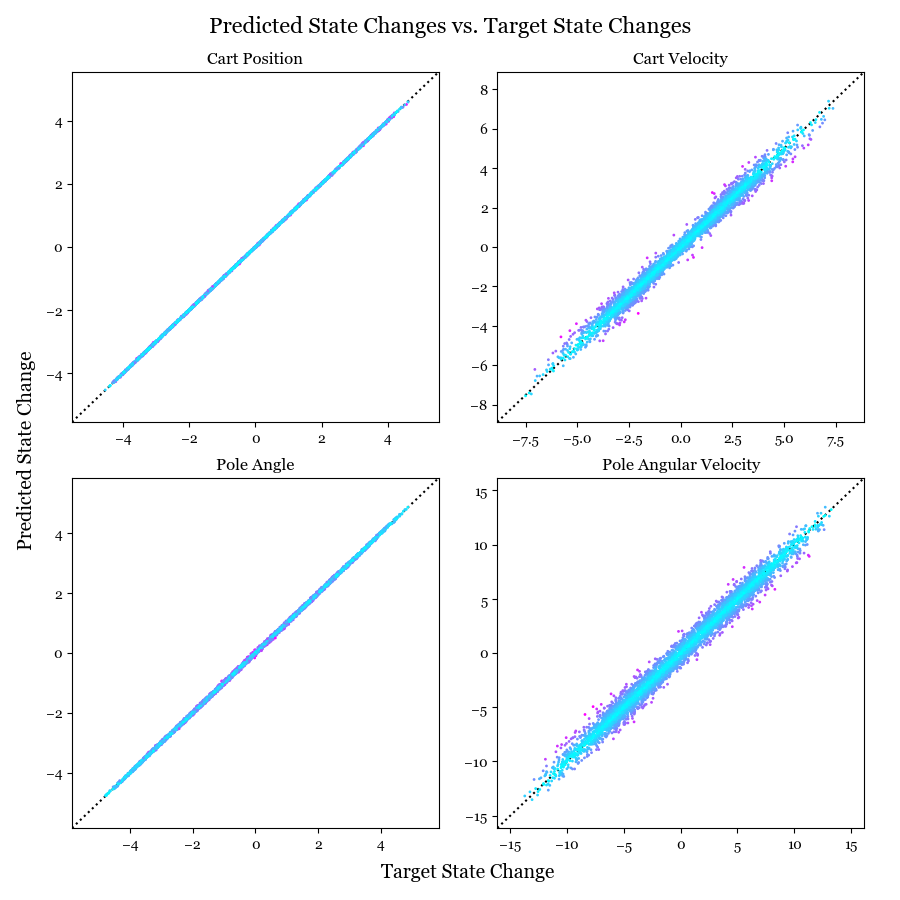

Text(0.03, 0.5, 'Predicted State Change')

In [24]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, num=44, figsize=(9,9))
fig.subplots_adjust(wspace=0.16, hspace=0.16, top=0.92, bottom=0.08, left=0.08, right=0.96)

titles = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Angular Velocity"]

predictions = np.array( [ nonlinear_model(state) for state in X ] )

for i, ax in enumerate( [ax1, ax2, ax3, ax4] ):
    
    x, y = predictions[:,i], Y[:,i]
    c = np.abs(x - y)
    
    extent = np.max( ( np.concatenate([x, y]) ) ) * 1.2
    
    ax.scatter( y, x, s=1, c=c, cmap="cool", zorder=2 )
    ax.set_xlim(-extent, extent)
    ax.set_ylim(-extent, extent)
    
    ax.plot( [-extent, extent], [-extent, extent], color="black", linestyle="dotted", zorder=1 )
    
    ax.set_title( titles[i] )
    

fig.text(0.5, 0.97, 'Predicted State Changes vs. Target State Changes', ha='center', va='center', fontsize=16)
fig.text(0.52, 0.03, 'Target State Change', ha='center', va='center', fontsize=14)
fig.text(0.03, 0.5, 'Predicted State Change', ha='center', va='center', rotation='vertical', fontsize=14)

## Target State Change vs Predictions, Including Force

I was able to use essentially the same code as for task 2.1 for fitting the model including the force input, so the results are very similar; for example in the above scatter plot comparing target to predicted state change the points all lie close to the ideal line.

In [25]:
# sweep over different initial pole angles and angvels and find the subsequent change in state

# number of steps to vary the intial conditions across their range
Nsteps = 30

# setup some intial conditions to loop over, varying the intial pole angle and angular velocity

initial_cart_positions  = np.array( [2] )
initial_cart_velocities = np.array( [4] )
initial_pole_angles     = np.linspace( -np.pi, np.pi, num=Nsteps )
initial_pole_angvels    = np.array( [3] )
initial_actions         = np.linspace( -15, 15, num=Nsteps )

# create array of initial state vectors

initial_states = np.array( np.meshgrid(
    initial_cart_positions, 
    initial_cart_velocities, 
    initial_pole_angles, 
    initial_pole_angvels,
    initial_actions
)).T.squeeze()

# get 2d arrays of subsquent state changes and predictions

state_changes = [ CartPole.perform_action5( state ) - state for state in initial_states.reshape( (Nsteps**2,5) ) ]
state_changes = np.array( state_changes ).reshape( (Nsteps, Nsteps, 5) )

modelled_changes = [ nonlinear_model( state ) for state in initial_states.reshape( (Nsteps**2,5) ) ]
modelled_changes = np.array( modelled_changes ).reshape( (Nsteps, Nsteps, 5) )

<IPython.core.display.Javascript object>


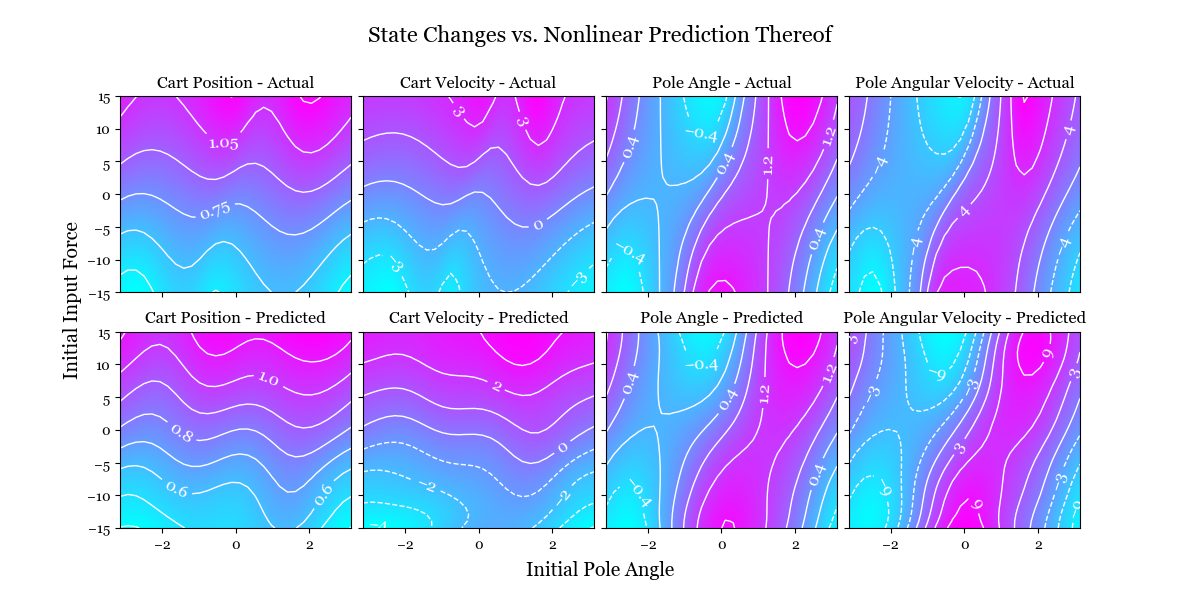

Text(0.06, 0.5, 'Initial Input Force')

In [26]:
fig, axs = plt.subplots(2, 4, num=45, figsize=(12,6), sharex=True, sharey=True )
fig.subplots_adjust(wspace=0.05, hspace=0.2, top=0.84, bottom=0.12, left=0.1, right=0.9)

titles = [["Cart Position - Actual", "Cart Velocity - Actual", "Pole Angle - Actual", "Pole Angular Velocity - Actual"],
          ["Cart Position - Predicted", "Cart Velocity - Predicted", "Pole Angle - Predicted", "Pole Angular Velocity - Predicted"]]

# plot nonlinear prediction contours

for row, axrow in enumerate(axs):
    
    changes = [ state_changes, modelled_changes ][row]
    
    for col, ax in enumerate(axrow):

        ax.imshow( changes[:,:,col], interpolation="bicubic", extent=(-np.pi, np.pi, -15, 15), aspect='auto', cmap="cool", origin='lower' )
        contour = ax.contour( initial_states[0,:,2], initial_states[:,0,4], changes[:,:,col], colors="white", linewidths=1 )
        ax.clabel( contour, contour.levels[1::2], inline=True, fontsize=12 )
        
        ax.set_title( titles[row][col] )
    
fig.text(0.5, 0.94, 'State Changes vs. Nonlinear Prediction Thereof', ha='center', va='center', fontsize=16)
fig.text(0.5, 0.05, 'Initial Pole Angle', ha='center', va='center', fontsize=14)
fig.text(0.06, 0.5, 'Initial Input Force', ha='center', va='center', rotation='vertical', fontsize=14)


Above I have plotted contours of the target state changes as well as the predictions from the nonlinear model. I have varied the initial pole angle along the x axis and initial input force along the y axis, and there is good agreement between the two sets of contours. However, discrepancies are easier to find in these plots than in those without the force input.

<IPython.core.display.Javascript object>


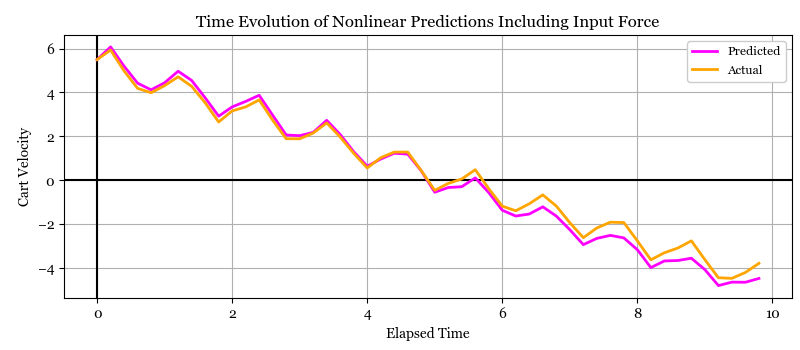

In [27]:
fig, ax = plt.subplots(1, 1, num=43, figsize=(8,3.5))
fig.subplots_adjust(top=0.9, bottom=0.15, left=0.08, right=0.99)
sf3utility.setup_phase_portrait( ax )

# small oscillations about stable equilibrium

actual_state = np.array(    [0, 5.5, np.pi - 1, 3, -1] )
predicted_state = np.array( [0, 5.5, np.pi - 1, 3, -1] )

prediction_states = []
actual_states = []
time = []

for i in range(50):
    
    prediction_states.append( predicted_state )
    actual_states.append( actual_state )
    time.append( i * 0.2 )
    
    predicted_state = nonlinear_model( predicted_state ) + predicted_state
    actual_state = CartPole.perform_action5( actual_state )

prediction_states = np.array( prediction_states )
actual_states = np.array( actual_states )
time = np.array( time )

x = time
y1 = prediction_states[:,1]
y2 = actual_states[:,1]

ax.plot( x, y1, color="magenta", linewidth=2, label="Predicted" )
ax.plot( x, y2, color="orange", linewidth=2, label="Actual" )

ax.set_title( "Time Evolution of Nonlinear Predictions Including Input Force" )
ax.set_xlabel( "Elapsed Time" )
ax.set_ylabel( "Cart Velocity" )

ax.legend( loc="upper right", prop={'size': 9}, facecolor='white', framealpha=1 )

## Time Evolution Modelling

Above is the time evolution of the cart velocity with predictions in magenta and analytic in orange; the close agreement shows that the model has understood this motion well. Although this initial condition leads to good agreement, others lead to divergence more quickly. We might expect the predictions when including the force input to be worse since the state space has become much larger; I have set the input force to be between -15 and 15 in training data so the additional travel in this dimension effectively reduces the data density and basis function density in the state space. In other words the model has to fit a larger and more complex state change function with sparser information about it and using the same number of kernels. Using more basis functions and datapoints to compensate for this effect makes the fitting process take much longer.